In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import h5py
import pickle
import os
os.chdir("neuron_files/allen/")
from neuron import h
os.chdir("../../")
import sys
import pandas as pd
np.set_printoptions(threshold=sys.maxsize)


In [2]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

# Plot for GA result
def final_indv_plot(param_names, final_best_indv, title, file_path_to_save=None, max_xtic=1, vert_size=10):
    plt.figure(figsize=(cm_to_in(8.5), cm_to_in(vert_size)))
    ax = plt.gca()
    y_pos = np.arange(len(param_names))
    ax.barh(y_pos, final_best_indv, height=0.5, align='center', linestyle='-', color='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(param_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.axvline(x=0, color='black', linewidth=0.4 ,linestyle='--')
    ax.set_xlim(0, max_xtic)
    ax.set_xticks([0, max_xtic])
    ax.set_ylabel('Parameters')
    ax.set_xlabel('Normalized Distance')
    ax.set_title('Deviation From Truth Value ' + title)
    if file_path_to_save:
        plt.savefig(file_path_to_save+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

# Code for optimization results analysis
def read_and_normalize_with_neg(opt_result_path, base, lower_bounds, upper_bounds):
    with open(opt_result_path, 'rb') as f:
        best_indvs = pickle.load(f, encoding = "latin1")
    normalized_indvs = []
    for i in range(len(best_indvs)):
        normalized = []
        for j in range(len(best_indvs[i])):
            if (best_indvs[i][j] < base[j]):
                new_value = abs((best_indvs[i][j] - base[j])/(ubs[j] - base[j]))
                normalized.append(new_value)
            else:
                new_value = abs((best_indvs[i][j] - base[j])/(ubs[j] - base[j]))
                normalized.append(new_value)
        normalized_indvs.append(normalized)
    return normalized_indvs, best_indvs

def plot_stim_volts_pair(stim, volts, title_stim, title_volts, file_path_to_save=None):
    plt.figure(figsize=(cm_to_in(8.5+6), cm_to_in(12)))
    plt.subplot(2, 1, 1)
    plt.title(title_stim)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (nA)')
    plt.plot(stim, color='black', linewidth=0.7)
    plt.subplot(2, 1, 2)
    plt.title('Voltage Response '+title_volts)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    plt.plot(volts[0], label='target', color='black')
    plt.plot(volts[1], label='best individual', color='crimson')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout(pad=1)
    if file_path_to_save:
        plt.savefig(file_path_to_save+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

def cm_to_in(cm):
    return cm/2.54

# Running a single volt
def run_single_volts(param_set, stim_data, ntimestep, dt):
    run_file = './neuron_files/run_model_cori.hoc'
    h.load_file(run_file)
    total_params_num = len(param_set)
    timestamps = np.array([dt for i in range(ntimestep)])
    h.curr_stim = h.Vector().from_python(stim_data)
    h.transvec = h.Vector(total_params_num, 1).from_python(param_set)
    h.stimtime = h.Matrix(1, len(timestamps)).from_vector(h.Vector().from_python(timestamps))
    h.ntimestep = ntimestep
    h.runStim()
    out = h.vecOut.to_python()
    return np.array(out)

def plot_comb_scores(opt_path, score_path, title, plot_save_path=None):
    opt_result = h5py.File(opt_path)
    ordered_score_function_list = [e.decode('ascii') for e in opt_result['ordered_score_function_list'][:]]
    optimization_stim_names = [e.decode('ascii') for e in opt_result['opt_stim_name_list'][:]]
    optimization_weightes = opt_result['opt_weight_list'][:]
    best_stims_score_list = []
    for score_name in optimization_stim_names:
        curr_score_data = h5py.File(score_path+score_name+'_scores.hdf5', 'r')
        for sf in ordered_score_function_list:
            curr_stim_sf_pair = curr_score_data['norm_pin_scores_'+sf][:]
            best_stims_score_list.append(curr_stim_sf_pair)
    combined_score = sum([best_stims_score_list[i]*optimization_weightes[i] for i in range(len(optimization_weightes))])
    plt.figure(figsize=(cm_to_in(8.5), cm_to_in(5)))
    plt.title(title)
    plt.xlabel('Parameter Set Rank')
    plt.ylabel('Weighted Score')
    time_step = range(len(combined_score))
    plt.scatter(time_step, combined_score, s=1, color='black')
    if plot_save_path:
        plt.savefig(plot_save_path+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")


# Blue Brain Project Model

In [3]:
# For overall params
params_bbp = list(pd.read_csv('./params/params_bbp_full_gpu_tuned_10_based.csv').iloc[:,0])
print(params_bbp)

['g_pas_all', 'e_pas_all', 'gNaTa_tbar_NaTa_t_axonal', 'gK_Tstbar_K_Tst_axonal', 'gNap_Et2bar_Nap_Et2_axonal', 'gK_Pstbar_K_Pst_axonal', 'gSKv3_1bar_SKv3_1_axonal', 'gCa_LVAstbar_Ca_LVAst_axonal', 'gCa_HVAbar_Ca_HVA_axonal', 'gSKv3_1bar_SKv3_1_somatic', 'gCa_HVAbar_Ca_HVA_somatic', 'gNaTs2_tbar_NaTs2_t_somatic', 'gCa_LVAstbar_Ca_LVAst_somatic', 'gIh_dend']


In [4]:
test_stim1_name = '65'
test_stim2_name = '51_2'
train_stim1_name = '4'
train_stim2_name = '53_3'
stims = h5py.File('./stims/allen_data_stims_10000.hdf5', 'r')
test_stim1 = stims[test_stim1_name][:]
test_stim2 = stims[test_stim2_name][:]
train_stim1 = stims[train_stim1_name][:]
train_stim2 = stims[train_stim2_name][:]
test_stim1_dt = stims[test_stim1_name+'_dt'][0]
test_stim2_dt = stims[test_stim2_name+'_dt'][0]
train_stim1_dt = stims[train_stim1_name+'_dt'][0]
train_stim2_dt = stims[train_stim2_name+'_dt'][0]

In [5]:
target_volts_path = './target_volts/allen_data_target_volts_10000.hdf5'
target_volts = h5py.File(target_volts_path, 'r')
test_target_volts1 = target_volts[test_stim1_name][:]
test_target_volts2 = target_volts[test_stim2_name][:]
train_target_volts1 = target_volts[train_stim1_name][:]
train_target_volts2 = target_volts[train_stim2_name][:]

## Initial params test

In [6]:
gpu_tuned_init_params = list(pd.read_csv('./params/params_bbp_full_gpu_tuned_10_based.csv').iloc[:,1])

### Train stim response

	1 
	1 
Setting temperature to 34.000000 C
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


/global/cscratch1/sd/zladd/axonstandardized/playground/neuroGPU_tuned/neuron_files/
	1 
	1 
finshed run matrix
finshed run matrix


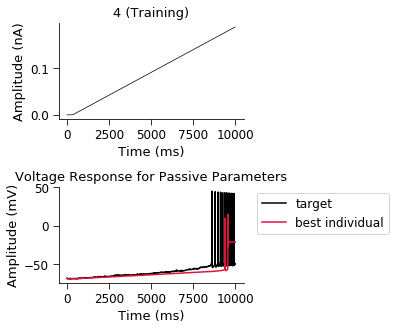

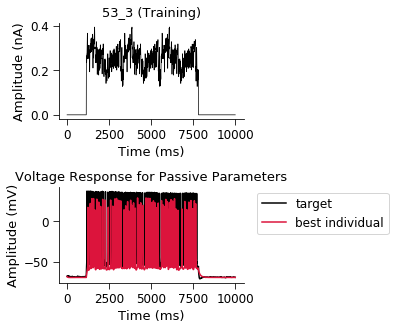

In [7]:
train_volts_full_best_response1 = run_single_volts(gpu_tuned_init_params, train_stim1, ntimestep=10000, dt=train_stim1_dt)
file_save_path = './plots/initial_tuning/train_bbp_full_allen_stim1'
plot_stim_volts_pair(train_stim1, [train_target_volts1, train_volts_full_best_response1], train_stim1_name+' (Training)', 'for Passive Parameters', file_save_path)

train_volts_full_best_response2 = run_single_volts(gpu_tuned_init_params, train_stim2, ntimestep=10000, dt=train_stim2_dt)
file_save_path = './plots/initial_tuning/train_bbp_full_allen_stim2'
plot_stim_volts_pair(train_stim2, [train_target_volts2, train_volts_full_best_response2], train_stim2_name+' (Training)', 'for Passive Parameters', file_save_path)


### Test stim response

finshed run matrix
finshed run matrix


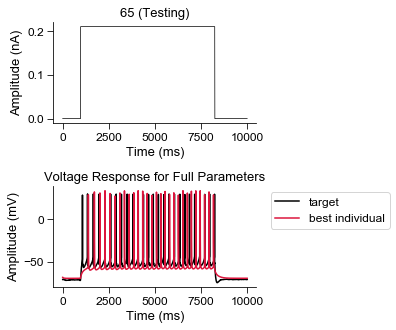

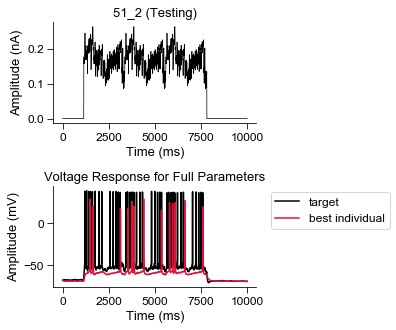

In [35]:
test_volts_full_best_response1 = run_single_volts(gpu_tuned_init_params, test_stim1, ntimestep=10000, dt=test_stim1_dt)
file_save_path = './plots/initial_tuning/test_bbp_full_allen_stim1'
plot_stim_volts_pair(test_stim1, [test_target_volts1, test_volts_full_best_response1], test_stim1_name+' (Testing)', 'for Full Parameters', file_save_path)

test_volts_full_best_response2 = run_single_volts(gpu_tuned_init_params, test_stim2, ntimestep=10000, dt=test_stim2_dt)
file_save_path = './plots/initial_tuning/test_bbp_full_allen_stim2'
plot_stim_volts_pair(test_stim2, [test_target_volts2, test_volts_full_best_response2], test_stim2_name+' (Testing)', 'for Full Parameters', file_save_path)


### Action potential tune test

finshed run matrix


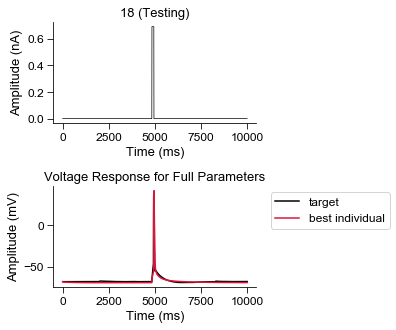

In [36]:
ap_tune_stim_name = '18'
ap_tune_stim = stims[ap_tune_stim_name][:]
ap_tune_stim_dt = stims[ap_tune_stim_name+'_dt'][0]
ap_tune_target_response = target_volts[ap_tune_stim_name][:]
ap_tune_best_response = run_single_volts(gpu_tuned_init_params, ap_tune_stim*2, ntimestep=10000, dt=ap_tune_stim_dt)
file_save_path = './plots/initial_tuning/test_bbp_full_allen_ap_tune'
plot_stim_volts_pair(ap_tune_stim, [ap_tune_target_response, ap_tune_best_response], ap_tune_stim_name+' (Testing)', 'for Full Parameters', file_save_path)


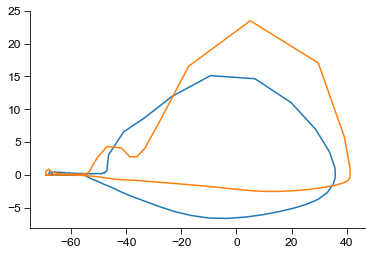

In [10]:
plt.plot(ap_tune_target_response, np.gradient(ap_tune_target_response))
plt.plot(ap_tune_best_response, np.gradient(ap_tune_best_response))

## Parse GA result

### Score function

/global/homes/z/zladd/.conda/envs/.env/lib/python3.6/site-packages/ipykernel_launcher.py:97: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Stims used to train:
4
23
22
48_3
53_3
51_1
58
48_1
66
48_2
44
16
38
28
13
18
15
14


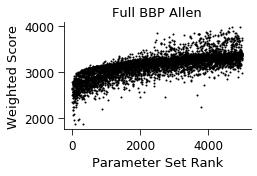

In [16]:
bbp_full_allen_opt_path = './objectives/multi_stim_bbp_full_allen_gpu_tune_18_stims.hdf5'
bbp_full_allen_score_path = './scores/allen_scores/'
bbp_full_allen_plot_path = './plots/scores_bbp_full_allen'
plot_comb_scores(bbp_full_allen_opt_path, bbp_full_allen_score_path, 'Full BBP Allen', bbp_full_allen_plot_path)
print('Stims used to train:')
train_stim_names = h5py.File(bbp_full_allen_opt_path, 'r')['opt_stim_name_list'][:]
for e in train_stim_names:
    print(e.decode('ascii'))


In [17]:
run_name = 'zero_penalty'

### Compare orig with genetic algorithm result

[ 3.56e-06 -6.66e+01  5.25e+00  3.85e-01  3.85e-02  3.81e+00  8.87e+00
  2.09e-02  2.71e-04  3.26e-02  4.01e-04  1.48e+00  6.98e-04  3.14e-04]


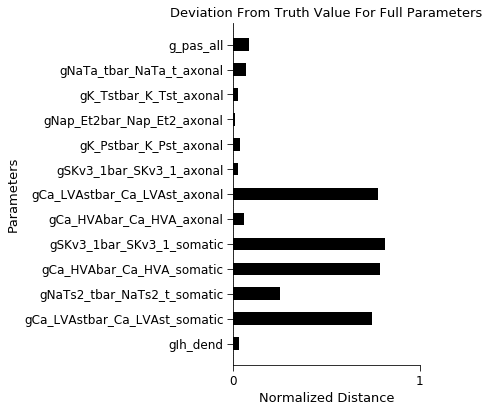

In [18]:
GA_result_path = './GA_results/best_indvs_gen_99_cpu_zero_penalty.pkl'
params_path = './params/params_bbp_full_gpu_tuned_10_based.csv'
df = pd.read_csv(params_path, skipinitialspace=True, usecols=['Base value'])
base_full = df.values.T[0]
#base_full = bbp_params_base
opt_ind = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
base = [base_full[i] for i in opt_ind]
lbs = [0.1*p for p in base]
ubs = [10*p for p in base]
params_bbp_full = [params_bbp[i] for i in opt_ind]
normalized_indvs_full_bbp, best_indvs_full_bbp = read_and_normalize_with_neg(GA_result_path, base, lbs, ubs)
file_path_to_save = './plots/'+run_name+'/GA_bbp_allen_compare_to_gpu_tune'
final_indv_plot(params_bbp_full, normalized_indvs_full_bbp[-1], 'For Full Parameters', file_path_to_save, 1, 16)
print(base_full)


### Train stim response

In [19]:
best_full = list(base_full)
for i in range(len(opt_ind)):
    best_full[opt_ind[i]] = best_indvs_full_bbp[-1][i]
#best_full[-1] = 4.121212121e-03
print(np.array(best_full))


[ 7.74499616e-07 -6.66000000e+01  2.06086741e+00  2.94214776e-01
  4.14697824e-02  5.10823041e+00  6.72319024e+00  1.66594005e-01
  1.27121092e-04  2.70593946e-01  3.24006841e-03  4.80769239e+00
  5.35326496e-03  4.06406254e-04]


In [ ]:
train_volts_full_best_response1 = run_single_volts(best_full, train_stim1, ntimestep=10000, dt=train_stim1_dt)
file_save_path = './plots/'+run_name+'/train_bbp_full_allen_stim1'
plot_stim_volts_pair(train_stim1, [train_target_volts1, train_volts_full_best_response1], train_stim1_name+' (Training)', 'for Passive Parameters', file_save_path)

train_volts_full_best_response2 = run_single_volts(best_full, train_stim2, ntimestep=10000, dt=train_stim2_dt)
file_save_path = './plots/'+run_name+'/train_bbp_full_allen_stim2'
plot_stim_volts_pair(train_stim2, [train_target_volts2, train_volts_full_best_response2], train_stim2_name+' (Training)', 'for Passive Parameters', file_save_path)


### Test stim response

finshed run matrix
finshed run matrix


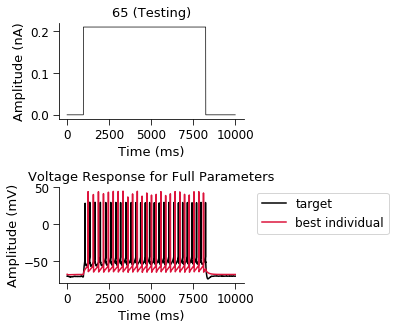

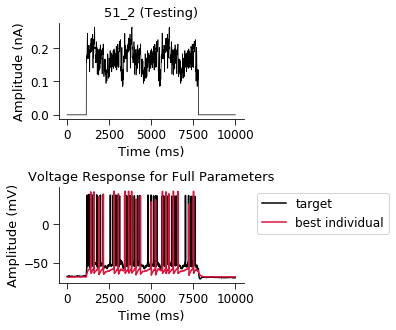

In [12]:
test_volts_full_best_response1 = run_single_volts(best_full, test_stim1, ntimestep=10000, dt=test_stim1_dt)
file_save_path = './plots/'+run_name+'/test_bbp_full_allen_stim1'
plot_stim_volts_pair(test_stim1, [test_target_volts1, test_volts_full_best_response1], test_stim1_name+' (Testing)', 'for Full Parameters', file_save_path)

test_volts_full_best_response2 = run_single_volts(best_full, test_stim2, ntimestep=10000, dt=test_stim2_dt)
file_save_path = './plots/'+run_name+'/test_bbp_full_allen_stim2'
plot_stim_volts_pair(test_stim2, [test_target_volts2, test_volts_full_best_response2], test_stim2_name+' (Testing)', 'for Full Parameters', file_save_path)


finshed run matrix


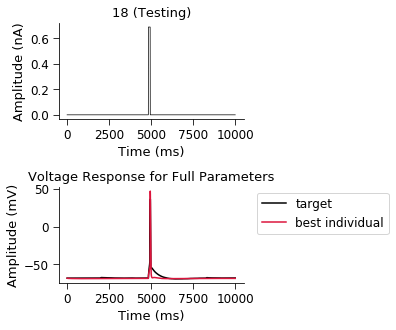

In [13]:
ap_tune_stim_name = '18'
ap_tune_stim = stims[ap_tune_stim_name][:]
ap_tune_stim_dt = stims[ap_tune_stim_name+'_dt'][0]
ap_tune_target_response = target_volts[ap_tune_stim_name][:]
ap_tune_best_response = run_single_volts(best_full, ap_tune_stim*2, ntimestep=10000, dt=ap_tune_stim_dt)
file_save_path = './plots/'+run_name+'/test_bbp_full_allen_ap_tune'
plot_stim_volts_pair(ap_tune_stim, [ap_tune_target_response, ap_tune_best_response], ap_tune_stim_name+' (Testing)', 'for Full Parameters', file_save_path)


0.034999999999999996


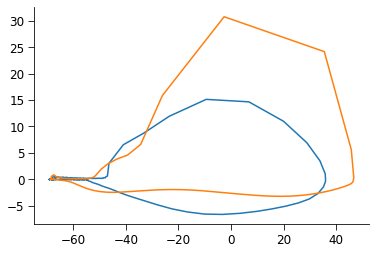

In [14]:
plt.plot(ap_tune_target_response, np.gradient(ap_tune_target_response))
plt.plot(ap_tune_best_response, np.gradient(ap_tune_best_response))
print(ap_tune_stim_dt)

In [19]:
opt_stim_list = ['4',
 '23',
 '22',
 '48_3',
 '53_3',
 '51_1',
 '58',
 '48_1',
 '66',
 '48_2',
 '44',
 '16',
 '38',
 '28',
 '13',
 '18',
 '15',
 '14']

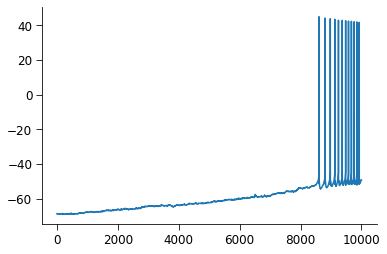

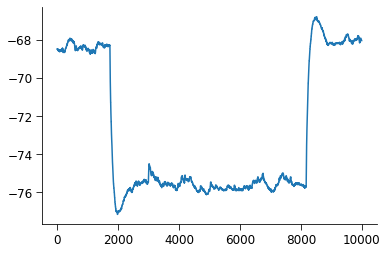

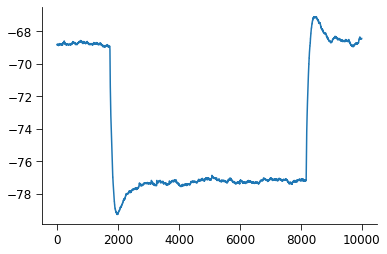

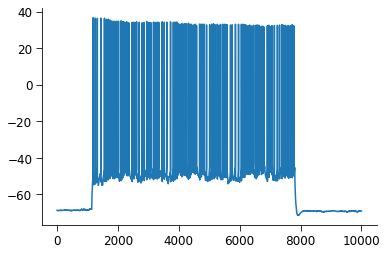

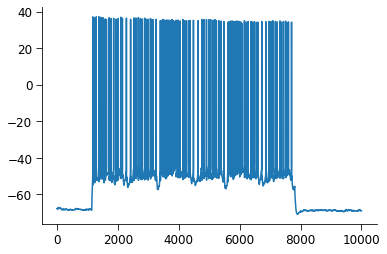

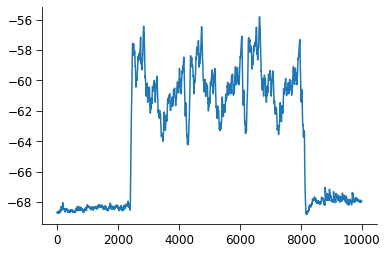

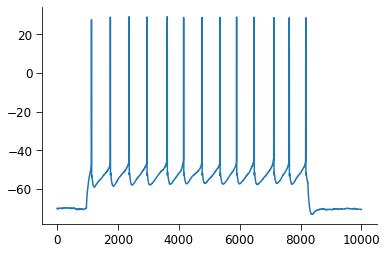

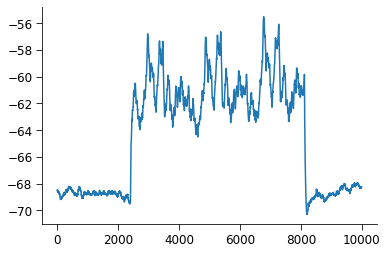

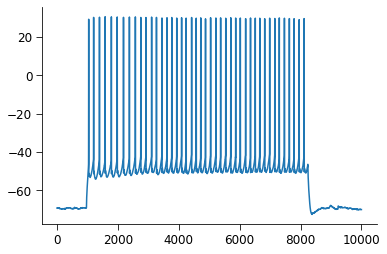

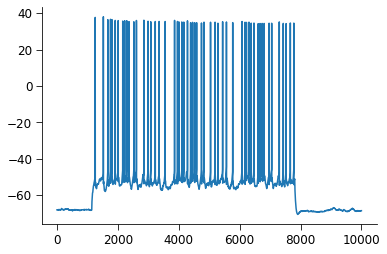

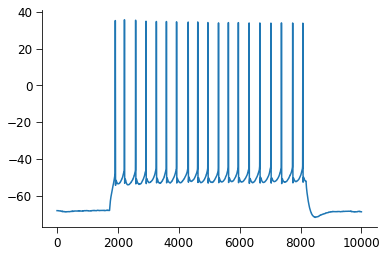

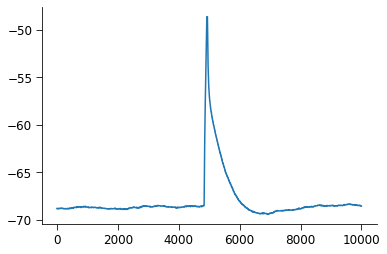

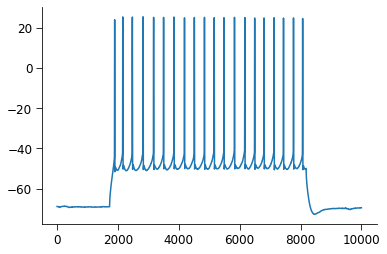

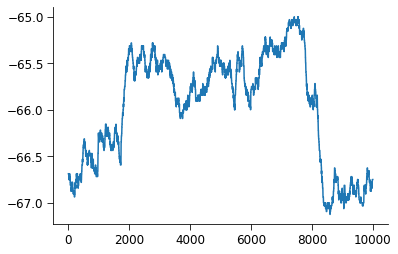

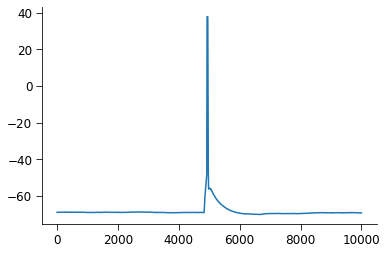

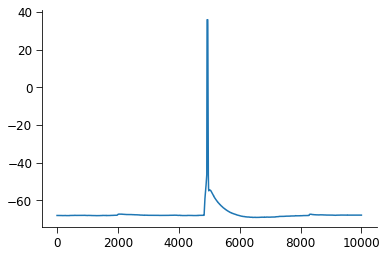

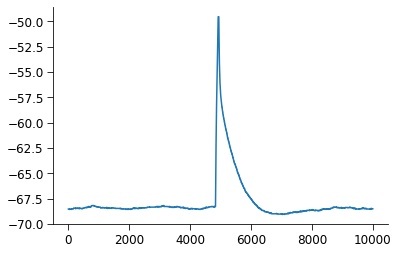

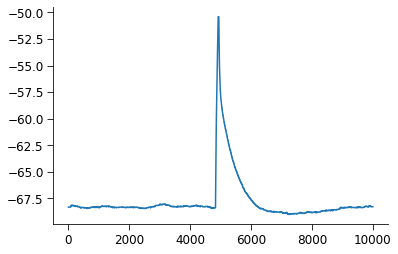

In [26]:
for opt_stim in opt_stim_list:
    plt.figure()
    plt.plot(target_volts[opt_stim][:])